<a href="https://colab.research.google.com/github/H-T0rres/Scorpian-GAN-staractart/blob/main/AbstractArtCTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
project_name = 'abstract art'

In [6]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Downloading and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.  Follow these steps to find your API credentials:

1. Sign in to  [https://kaggle.com/](https://kaggle.com),  then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file `kaggle.json` with the following contents:

```
{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
```

3. When you run `opendatsets.download`, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

Note that you need to download the `kaggle.json` file only once. On Google Colab, you can also upload the `kaggle.json` file using the files tab, and the credentials will be read automatically.


In [7]:
!pip install opendatasets --upgrade --quiet

In [8]:
import opendatasets as od
#kaggle link HERE
dataset_url = 'https://www.kaggle.com/datasets/bryanb/abstract-art-gallery?resource=download'
od.download(dataset_url)

100%|██████████| 693M/693M [00:06<00:00, 104MB/s] 


In [9]:
import os
#changing the kaggale dataset will require editing to the file path
DATA_DIR = './abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery_2', 'Abstract_gallery']


In [10]:
print(os.listdir(DATA_DIR+'/Abstract_gallery/Abstract_gallery')[:10])


['Abstract_image_242.jpg', 'Abstract_image_2731.jpg', 'Abstract_image_1753.jpg', 'Abstract_image_1357.jpg', 'Abstract_image_1411.jpg', 'Abstract_image_2237.jpg', 'Abstract_image_2478.jpg', 'Abstract_image_510.jpg', 'Abstract_image_2106.jpg', 'Abstract_image_777.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [14]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

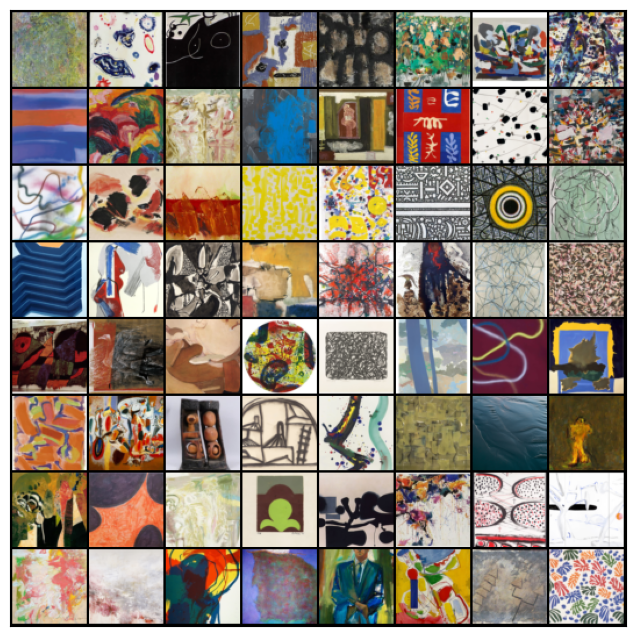

In [17]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [18]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [19]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
import torch.nn as nn

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 200
# you could change this and results would be a little different
#the number of latent could contain certain parts of the image like hair, mouth, and expression
#increase the size to increase the detail

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.


> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


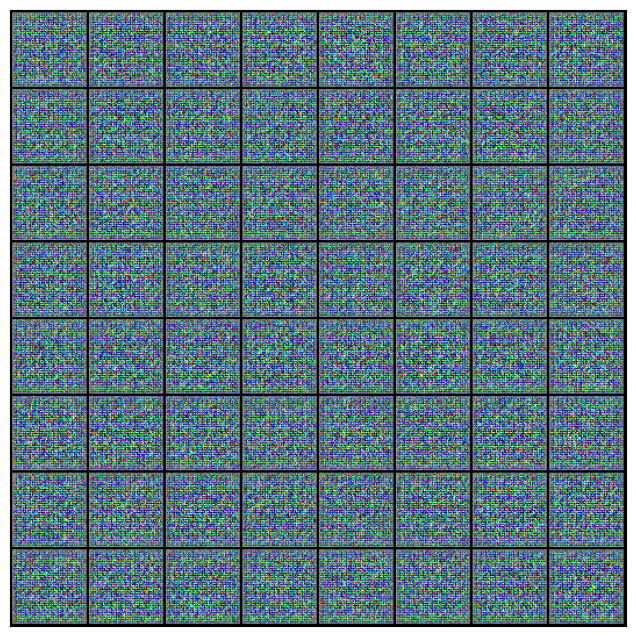

In [26]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [33]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


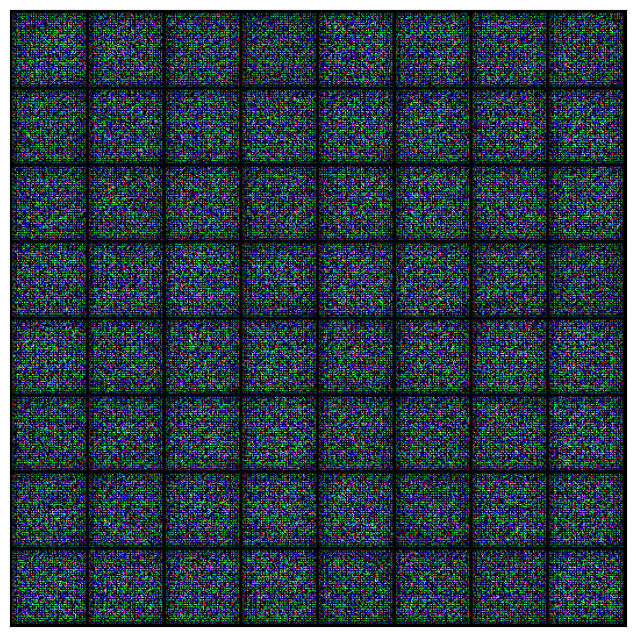

In [34]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [35]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [36]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [37]:
lr = 0.0002
epochs = 200
#change epochs for more generations, may take longer to create

In [38]:
history = fit(epochs, lr)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 9.7876, loss_d: 0.2839, real_score: 0.7725, fake_score: 0.0021
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 11.5254, loss_d: 0.2703, real_score: 0.8003, fake_score: 0.0003
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 6.8038, loss_d: 0.1161, real_score: 0.9043, fake_score: 0.0014
Saving generated-images-0003.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 11.7297, loss_d: 0.2170, real_score: 0.8409, fake_score: 0.0000
Saving generated-images-0004.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 9.1939, loss_d: 0.4428, real_score: 0.9497, fake_score: 0.3154
Saving generated-images-0005.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 4.1880, loss_d: 0.4897, real_score: 0.7468, fake_score: 0.1362
Saving generated-images-0006.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 7.0304, loss_d: 0.5085, real_score: 0.9362, fake_score: 0.3282
Saving generated-images-0007.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 6.2124, loss_d: 1.0473, real_score: 0.8225, fake_score: 0.5382
Saving generated-images-0008.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 3.7845, loss_d: 0.2125, real_score: 0.8565, fake_score: 0.0490
Saving generated-images-0009.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 1.1980, loss_d: 0.2947, real_score: 0.9170, fake_score: 0.1761
Saving generated-images-0010.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 2.2387, loss_d: 1.0260, real_score: 0.7483, fake_score: 0.4451
Saving generated-images-0011.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 2.2348, loss_d: 0.4201, real_score: 0.7907, fake_score: 0.1526
Saving generated-images-0012.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 1.6383, loss_d: 0.6979, real_score: 0.5715, fake_score: 0.0696
Saving generated-images-0013.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 2.1575, loss_d: 0.5646, real_score: 0.6616, fake_score: 0.1059
Saving generated-images-0014.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 2.3903, loss_d: 0.6414, real_score: 0.6836, fake_score: 0.1875
Saving generated-images-0015.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 4.2795, loss_d: 0.4156, real_score: 0.8030, fake_score: 0.1415
Saving generated-images-0016.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 2.9864, loss_d: 0.7721, real_score: 0.5561, fake_score: 0.0809
Saving generated-images-0017.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 3.6884, loss_d: 0.6220, real_score: 0.8959, fake_score: 0.3701
Saving generated-images-0018.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 1.1418, loss_d: 0.8455, real_score: 0.5473, fake_score: 0.1174
Saving generated-images-0019.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.0919, loss_d: 0.4645, real_score: 0.8045, fake_score: 0.1936
Saving generated-images-0020.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 2.7775, loss_d: 0.5252, real_score: 0.7897, fake_score: 0.2128
Saving generated-images-0021.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 2.1008, loss_d: 0.5980, real_score: 0.6924, fake_score: 0.1441
Saving generated-images-0022.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 2.6685, loss_d: 0.3602, real_score: 0.7730, fake_score: 0.0683
Saving generated-images-0023.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 3.8720, loss_d: 0.5632, real_score: 0.7960, fake_score: 0.2601
Saving generated-images-0024.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 2.1359, loss_d: 0.6427, real_score: 0.7867, fake_score: 0.2728
Saving generated-images-0025.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 3.9395, loss_d: 0.3842, real_score: 0.8508, fake_score: 0.1825
Saving generated-images-0026.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 2.4976, loss_d: 0.5448, real_score: 0.6553, fake_score: 0.0710
Saving generated-images-0027.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.2659, loss_d: 0.6060, real_score: 0.8168, fake_score: 0.2936
Saving generated-images-0028.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 2.6395, loss_d: 0.7922, real_score: 0.5063, fake_score: 0.0202
Saving generated-images-0029.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 2.4828, loss_d: 1.1099, real_score: 0.3912, fake_score: 0.0134
Saving generated-images-0030.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 4.5022, loss_d: 0.5991, real_score: 0.9270, fake_score: 0.3835
Saving generated-images-0031.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 3.2199, loss_d: 1.5850, real_score: 0.2742, fake_score: 0.0034
Saving generated-images-0032.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 4.0620, loss_d: 0.6609, real_score: 0.7763, fake_score: 0.3018
Saving generated-images-0033.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 3.4402, loss_d: 0.3100, real_score: 0.7917, fake_score: 0.0456
Saving generated-images-0034.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 4.7277, loss_d: 0.8628, real_score: 0.9607, fake_score: 0.5175
Saving generated-images-0035.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 5.5976, loss_d: 0.8658, real_score: 0.8397, fake_score: 0.4402
Saving generated-images-0036.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 3.2457, loss_d: 0.4879, real_score: 0.7826, fake_score: 0.1691
Saving generated-images-0037.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 3.4476, loss_d: 0.4755, real_score: 0.7250, fake_score: 0.1060
Saving generated-images-0038.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 3.4433, loss_d: 0.6674, real_score: 0.8500, fake_score: 0.3454
Saving generated-images-0039.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 1.5793, loss_d: 0.7943, real_score: 0.6002, fake_score: 0.1752
Saving generated-images-0040.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 5.4578, loss_d: 0.7817, real_score: 0.9421, fake_score: 0.4501
Saving generated-images-0041.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 2.4351, loss_d: 1.7568, real_score: 0.2447, fake_score: 0.0093
Saving generated-images-0042.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 5.6675, loss_d: 0.8183, real_score: 0.8899, fake_score: 0.4620
Saving generated-images-0043.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 2.2557, loss_d: 1.4082, real_score: 0.3185, fake_score: 0.0208
Saving generated-images-0044.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 3.6978, loss_d: 1.1613, real_score: 0.8509, fake_score: 0.5686
Saving generated-images-0045.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 0.9725, loss_d: 1.5708, real_score: 0.2765, fake_score: 0.0354
Saving generated-images-0046.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 2.0182, loss_d: 0.6744, real_score: 0.6593, fake_score: 0.1707
Saving generated-images-0047.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 4.0233, loss_d: 0.8952, real_score: 0.8845, fake_score: 0.4897
Saving generated-images-0048.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 5.2185, loss_d: 0.9643, real_score: 0.8978, fake_score: 0.5366
Saving generated-images-0049.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.8254, loss_d: 0.6202, real_score: 0.8905, fake_score: 0.3482
Saving generated-images-0050.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 5.1374, loss_d: 1.0405, real_score: 0.9410, fake_score: 0.5836
Saving generated-images-0051.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.0004, loss_d: 0.4526, real_score: 0.8485, fake_score: 0.2226
Saving generated-images-0052.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 1.8672, loss_d: 0.6562, real_score: 0.7166, fake_score: 0.2375
Saving generated-images-0053.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 4.3318, loss_d: 1.1235, real_score: 0.8700, fake_score: 0.5635
Saving generated-images-0054.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 2.9922, loss_d: 0.4496, real_score: 0.6845, fake_score: 0.0420
Saving generated-images-0055.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 3.2786, loss_d: 0.5922, real_score: 0.6691, fake_score: 0.1204
Saving generated-images-0056.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 2.2019, loss_d: 0.7115, real_score: 0.6911, fake_score: 0.2305
Saving generated-images-0057.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.9914, loss_d: 0.7316, real_score: 0.7470, fake_score: 0.3193
Saving generated-images-0058.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 4.6768, loss_d: 0.8138, real_score: 0.9527, fake_score: 0.4681
Saving generated-images-0059.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 4.4760, loss_d: 0.6143, real_score: 0.8910, fake_score: 0.3578
Saving generated-images-0060.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 3.9200, loss_d: 0.3668, real_score: 0.8701, fake_score: 0.1800
Saving generated-images-0061.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 5.7010, loss_d: 0.7924, real_score: 0.9323, fake_score: 0.4628
Saving generated-images-0062.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 2.3777, loss_d: 1.0495, real_score: 0.4410, fake_score: 0.0547
Saving generated-images-0063.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 1.8033, loss_d: 0.7617, real_score: 0.5767, fake_score: 0.1080
Saving generated-images-0064.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.0684, loss_d: 0.4477, real_score: 0.8073, fake_score: 0.1897
Saving generated-images-0065.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 1.9961, loss_d: 0.7901, real_score: 0.6047, fake_score: 0.1802
Saving generated-images-0066.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 2.5931, loss_d: 0.5578, real_score: 0.7646, fake_score: 0.2222
Saving generated-images-0067.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 3.8724, loss_d: 0.4698, real_score: 0.7933, fake_score: 0.1729
Saving generated-images-0068.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 2.6881, loss_d: 1.0288, real_score: 0.4232, fake_score: 0.0163
Saving generated-images-0069.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.2852, loss_d: 0.5507, real_score: 0.8148, fake_score: 0.2615
Saving generated-images-0070.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 1.9133, loss_d: 0.3928, real_score: 0.8256, fake_score: 0.1572
Saving generated-images-0071.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 4.0239, loss_d: 0.2754, real_score: 0.8979, fake_score: 0.1459
Saving generated-images-0072.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.0443, loss_d: 0.5883, real_score: 0.8151, fake_score: 0.2825
Saving generated-images-0073.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 2.9229, loss_d: 0.6387, real_score: 0.6998, fake_score: 0.2095
Saving generated-images-0074.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 4.0294, loss_d: 0.4516, real_score: 0.9509, fake_score: 0.3043
Saving generated-images-0075.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 4.1915, loss_d: 0.5473, real_score: 0.9563, fake_score: 0.3490
Saving generated-images-0076.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 2.5051, loss_d: 0.5305, real_score: 0.7276, fake_score: 0.1594
Saving generated-images-0077.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 1.3705, loss_d: 0.6815, real_score: 0.5552, fake_score: 0.0308
Saving generated-images-0078.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 7.3611, loss_d: 1.3748, real_score: 0.9609, fake_score: 0.6827
Saving generated-images-0079.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 3.1802, loss_d: 0.3679, real_score: 0.7710, fake_score: 0.0808
Saving generated-images-0080.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 1.9699, loss_d: 1.2261, real_score: 0.3441, fake_score: 0.0105
Saving generated-images-0081.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.8936, loss_d: 0.3571, real_score: 0.8995, fake_score: 0.2017
Saving generated-images-0082.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 2.5191, loss_d: 0.4088, real_score: 0.7516, fake_score: 0.0857
Saving generated-images-0083.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 2.8188, loss_d: 0.5159, real_score: 0.6620, fake_score: 0.0580
Saving generated-images-0084.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.1537, loss_d: 0.2780, real_score: 0.8822, fake_score: 0.1319
Saving generated-images-0085.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 2.2636, loss_d: 0.4281, real_score: 0.7640, fake_score: 0.1195
Saving generated-images-0086.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 2.9753, loss_d: 0.5486, real_score: 0.7859, fake_score: 0.2363
Saving generated-images-0087.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 6.2173, loss_d: 0.8132, real_score: 0.9429, fake_score: 0.4849
Saving generated-images-0088.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 2.7181, loss_d: 0.4098, real_score: 0.7260, fake_score: 0.0414
Saving generated-images-0089.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 3.6188, loss_d: 0.3324, real_score: 0.7539, fake_score: 0.0300
Saving generated-images-0090.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 1.4229, loss_d: 0.5943, real_score: 0.6021, fake_score: 0.0340
Saving generated-images-0091.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 3.2313, loss_d: 0.4568, real_score: 0.8069, fake_score: 0.1883
Saving generated-images-0092.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 3.1108, loss_d: 0.3690, real_score: 0.8464, fake_score: 0.1652
Saving generated-images-0093.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.7518, loss_d: 0.8442, real_score: 0.9721, fake_score: 0.4955
Saving generated-images-0094.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 2.1423, loss_d: 0.4648, real_score: 0.6998, fake_score: 0.0420
Saving generated-images-0095.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 3.6509, loss_d: 0.3046, real_score: 0.8611, fake_score: 0.1301
Saving generated-images-0096.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 1.6206, loss_d: 3.1722, real_score: 0.0688, fake_score: 0.0003
Saving generated-images-0097.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 5.8162, loss_d: 0.3705, real_score: 0.9438, fake_score: 0.2353
Saving generated-images-0098.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.0129, loss_d: 0.3660, real_score: 0.9124, fake_score: 0.2255
Saving generated-images-0099.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 3.7414, loss_d: 0.2259, real_score: 0.8940, fake_score: 0.0993
Saving generated-images-0100.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 4.1566, loss_d: 0.3623, real_score: 0.8721, fake_score: 0.1842
Saving generated-images-0101.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 1.3808, loss_d: 0.7189, real_score: 0.5425, fake_score: 0.0168
Saving generated-images-0102.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 2.9777, loss_d: 0.2728, real_score: 0.8310, fake_score: 0.0681
Saving generated-images-0103.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.7546, loss_d: 0.2643, real_score: 0.8782, fake_score: 0.1150
Saving generated-images-0104.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 6.0207, loss_d: 0.3758, real_score: 0.9498, fake_score: 0.2513
Saving generated-images-0105.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.6060, loss_d: 0.2916, real_score: 0.9262, fake_score: 0.1784
Saving generated-images-0106.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 2.3684, loss_d: 0.3250, real_score: 0.8154, fake_score: 0.0932
Saving generated-images-0107.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.7643, loss_d: 0.3360, real_score: 0.9236, fake_score: 0.2056
Saving generated-images-0108.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 6.1873, loss_d: 0.5207, real_score: 0.9386, fake_score: 0.3253
Saving generated-images-0109.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 3.4762, loss_d: 0.3023, real_score: 0.8162, fake_score: 0.0791
Saving generated-images-0110.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 3.1853, loss_d: 0.1809, real_score: 0.8769, fake_score: 0.0314
Saving generated-images-0111.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 3.1399, loss_d: 0.2686, real_score: 0.8646, fake_score: 0.0967
Saving generated-images-0112.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 4.6182, loss_d: 0.3578, real_score: 0.9876, fake_score: 0.2660
Saving generated-images-0113.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 3.0216, loss_d: 0.4788, real_score: 0.6753, fake_score: 0.0258
Saving generated-images-0114.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 3.1468, loss_d: 0.4120, real_score: 0.8056, fake_score: 0.1549
Saving generated-images-0115.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 2.5707, loss_d: 0.3155, real_score: 0.8113, fake_score: 0.0783
Saving generated-images-0116.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 2.9042, loss_d: 0.3442, real_score: 0.7648, fake_score: 0.0422
Saving generated-images-0117.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 3.3300, loss_d: 0.2591, real_score: 0.8796, fake_score: 0.1108
Saving generated-images-0118.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.5967, loss_d: 0.2336, real_score: 0.8558, fake_score: 0.0529
Saving generated-images-0119.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 4.3768, loss_d: 0.3485, real_score: 0.7428, fake_score: 0.0216
Saving generated-images-0120.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 4.5540, loss_d: 0.3275, real_score: 0.9560, fake_score: 0.2192
Saving generated-images-0121.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 3.9259, loss_d: 0.1718, real_score: 0.9189, fake_score: 0.0777
Saving generated-images-0122.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 6.3183, loss_d: 0.5849, real_score: 0.9395, fake_score: 0.3650
Saving generated-images-0123.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 4.6373, loss_d: 0.2041, real_score: 0.9565, fake_score: 0.1359
Saving generated-images-0124.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 2.0725, loss_d: 0.2979, real_score: 0.7983, fake_score: 0.0482
Saving generated-images-0125.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 7.2092, loss_d: 0.4729, real_score: 0.9835, fake_score: 0.3309
Saving generated-images-0126.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 3.8281, loss_d: 0.1923, real_score: 0.9548, fake_score: 0.1276
Saving generated-images-0127.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 2.7221, loss_d: 0.3194, real_score: 0.7805, fake_score: 0.0429
Saving generated-images-0128.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 3.2962, loss_d: 0.4026, real_score: 0.8578, fake_score: 0.2007
Saving generated-images-0129.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 3.5349, loss_d: 0.2609, real_score: 0.8797, fake_score: 0.1089
Saving generated-images-0130.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 3.6217, loss_d: 0.2692, real_score: 0.9683, fake_score: 0.1931
Saving generated-images-0131.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 2.8424, loss_d: 0.2457, real_score: 0.8515, fake_score: 0.0561
Saving generated-images-0132.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 2.0285, loss_d: 0.3312, real_score: 0.7563, fake_score: 0.0198
Saving generated-images-0133.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.5452, loss_d: 0.3806, real_score: 0.9100, fake_score: 0.2203
Saving generated-images-0134.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 7.8566, loss_d: 0.9132, real_score: 0.9757, fake_score: 0.4940
Saving generated-images-0135.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 3.9426, loss_d: 0.3470, real_score: 0.8801, fake_score: 0.1763
Saving generated-images-0136.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 2.7289, loss_d: 0.1983, real_score: 0.9180, fake_score: 0.0976
Saving generated-images-0137.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 4.3148, loss_d: 0.1894, real_score: 0.9583, fake_score: 0.1276
Saving generated-images-0138.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 3.9571, loss_d: 0.3671, real_score: 0.9290, fake_score: 0.2155
Saving generated-images-0139.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 3.3567, loss_d: 0.6547, real_score: 0.5725, fake_score: 0.0045
Saving generated-images-0140.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.4879, loss_d: 0.2820, real_score: 0.9671, fake_score: 0.1967
Saving generated-images-0141.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 3.1454, loss_d: 0.3471, real_score: 0.7940, fake_score: 0.0877
Saving generated-images-0142.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 3.5423, loss_d: 0.2383, real_score: 0.8496, fake_score: 0.0586
Saving generated-images-0143.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 3.7665, loss_d: 0.3030, real_score: 0.7737, fake_score: 0.0086
Saving generated-images-0144.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 2.7269, loss_d: 0.2079, real_score: 0.9129, fake_score: 0.0937
Saving generated-images-0145.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.8112, loss_d: 0.1898, real_score: 0.9492, fake_score: 0.1183
Saving generated-images-0146.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 3.6635, loss_d: 0.5586, real_score: 0.8074, fake_score: 0.2424
Saving generated-images-0147.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 7.1690, loss_d: 0.6469, real_score: 0.9789, fake_score: 0.3615
Saving generated-images-0148.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 1.2618, loss_d: 0.4242, real_score: 0.7173, fake_score: 0.0367
Saving generated-images-0149.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 3.9344, loss_d: 0.2674, real_score: 0.8463, fake_score: 0.0644
Saving generated-images-0150.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 4.2651, loss_d: 0.1311, real_score: 0.9505, fake_score: 0.0721
Saving generated-images-0151.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 2.5180, loss_d: 0.2761, real_score: 0.8021, fake_score: 0.0302
Saving generated-images-0152.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 3.6459, loss_d: 0.0927, real_score: 0.9506, fake_score: 0.0381
Saving generated-images-0153.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.8876, loss_d: 0.1280, real_score: 0.9353, fake_score: 0.0554
Saving generated-images-0154.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 3.9733, loss_d: 0.0992, real_score: 0.9411, fake_score: 0.0360
Saving generated-images-0155.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 3.9957, loss_d: 0.1496, real_score: 0.9322, fake_score: 0.0704
Saving generated-images-0156.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 2.5276, loss_d: 0.1943, real_score: 0.8507, fake_score: 0.0220
Saving generated-images-0157.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.8551, loss_d: 0.1032, real_score: 0.9410, fake_score: 0.0385
Saving generated-images-0158.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 4.6087, loss_d: 0.0917, real_score: 0.9523, fake_score: 0.0396
Saving generated-images-0159.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 4.5407, loss_d: 0.6784, real_score: 0.9269, fake_score: 0.3401
Saving generated-images-0160.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 1.6034, loss_d: 0.4859, real_score: 0.7133, fake_score: 0.0568
Saving generated-images-0161.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 3.8733, loss_d: 0.1025, real_score: 0.9675, fake_score: 0.0639
Saving generated-images-0162.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.1732, loss_d: 0.2381, real_score: 0.9023, fake_score: 0.1105
Saving generated-images-0163.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.4315, loss_d: 0.0919, real_score: 0.9421, fake_score: 0.0301
Saving generated-images-0164.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 4.4617, loss_d: 0.1277, real_score: 0.9278, fake_score: 0.0460
Saving generated-images-0165.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 4.9411, loss_d: 0.1139, real_score: 0.9580, fake_score: 0.0652
Saving generated-images-0166.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 4.7613, loss_d: 0.1172, real_score: 0.9308, fake_score: 0.0404
Saving generated-images-0167.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 4.1297, loss_d: 0.1153, real_score: 0.9216, fake_score: 0.0299
Saving generated-images-0168.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 2.3917, loss_d: 0.6178, real_score: 0.7299, fake_score: 0.1215
Saving generated-images-0169.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 7.7654, loss_d: 0.6132, real_score: 0.9557, fake_score: 0.3565
Saving generated-images-0170.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 3.7611, loss_d: 0.3678, real_score: 0.7561, fake_score: 0.0426
Saving generated-images-0171.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 4.5788, loss_d: 0.1879, real_score: 0.9417, fake_score: 0.1082
Saving generated-images-0172.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 4.8916, loss_d: 0.1197, real_score: 0.9549, fake_score: 0.0644
Saving generated-images-0173.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 3.5122, loss_d: 0.1582, real_score: 0.9062, fake_score: 0.0480
Saving generated-images-0174.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 4.1831, loss_d: 0.0880, real_score: 0.9824, fake_score: 0.0651
Saving generated-images-0175.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 5.3509, loss_d: 0.0694, real_score: 0.9568, fake_score: 0.0232
Saving generated-images-0176.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.8246, loss_d: 0.1847, real_score: 0.9531, fake_score: 0.1159
Saving generated-images-0177.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 2.9529, loss_d: 0.1512, real_score: 0.9026, fake_score: 0.0396
Saving generated-images-0178.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 4.8059, loss_d: 0.1547, real_score: 0.9712, fake_score: 0.1088
Saving generated-images-0179.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 4.8911, loss_d: 0.0625, real_score: 0.9820, fake_score: 0.0420
Saving generated-images-0180.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 6.5483, loss_d: 0.2832, real_score: 0.9912, fake_score: 0.2131
Saving generated-images-0181.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 5.1206, loss_d: 0.5912, real_score: 0.8362, fake_score: 0.2488
Saving generated-images-0182.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 3.1281, loss_d: 0.2678, real_score: 0.8963, fake_score: 0.1256
Saving generated-images-0183.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 3.4103, loss_d: 0.2791, real_score: 0.8731, fake_score: 0.1114
Saving generated-images-0184.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 3.2355, loss_d: 0.2173, real_score: 0.8760, fake_score: 0.0644
Saving generated-images-0185.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 3.2154, loss_d: 0.2239, real_score: 0.8754, fake_score: 0.0710
Saving generated-images-0186.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.3938, loss_d: 0.1419, real_score: 0.9143, fake_score: 0.0449
Saving generated-images-0187.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 4.3064, loss_d: 0.1054, real_score: 0.9486, fake_score: 0.0471
Saving generated-images-0188.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 2.9857, loss_d: 0.2501, real_score: 0.8735, fake_score: 0.0796
Saving generated-images-0189.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 2.8848, loss_d: 0.1765, real_score: 0.8958, fake_score: 0.0563
Saving generated-images-0190.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.4515, loss_d: 0.0740, real_score: 0.9597, fake_score: 0.0307
Saving generated-images-0191.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 6.1119, loss_d: 0.0797, real_score: 0.9385, fake_score: 0.0125
Saving generated-images-0192.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 2.9017, loss_d: 0.1917, real_score: 0.8793, fake_score: 0.0545
Saving generated-images-0193.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 4.6222, loss_d: 0.1204, real_score: 0.9246, fake_score: 0.0369
Saving generated-images-0194.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 5.0269, loss_d: 0.0547, real_score: 0.9766, fake_score: 0.0289
Saving generated-images-0195.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 6.4472, loss_d: 0.1717, real_score: 0.9834, fake_score: 0.1331
Saving generated-images-0196.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 4.6279, loss_d: 0.0716, real_score: 0.9693, fake_score: 0.0381
Saving generated-images-0197.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 3.0758, loss_d: 0.1278, real_score: 0.9036, fake_score: 0.0198
Saving generated-images-0198.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 3.3679, loss_d: 0.5396, real_score: 0.8926, fake_score: 0.2792
Saving generated-images-0199.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 4.5209, loss_d: 0.3452, real_score: 0.9062, fake_score: 0.1708
Saving generated-images-0200.png


In [39]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [48]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')
#Download the files if you wish to continue training your model

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [43]:
from IPython.display import Image

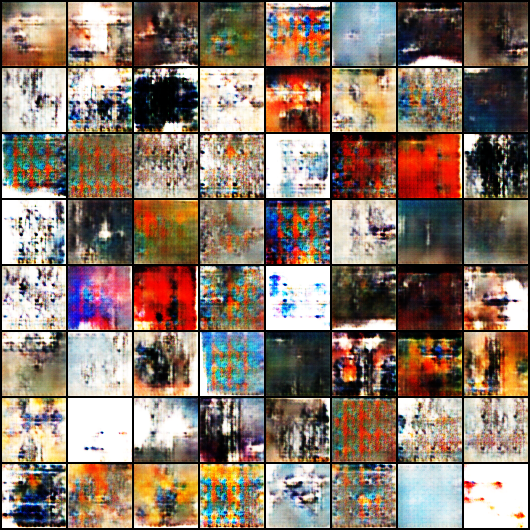

In [44]:
Image('./generated/generated-images-0100.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0030.png')

In [ ]:
Image('./generated/generated-images-0050.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [45]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Here's what it looks like:

![]()


We can also visualize how the loss changes over time. Visualizing
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



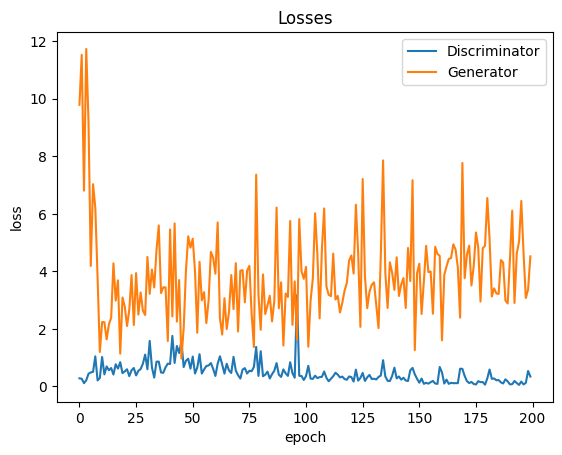

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

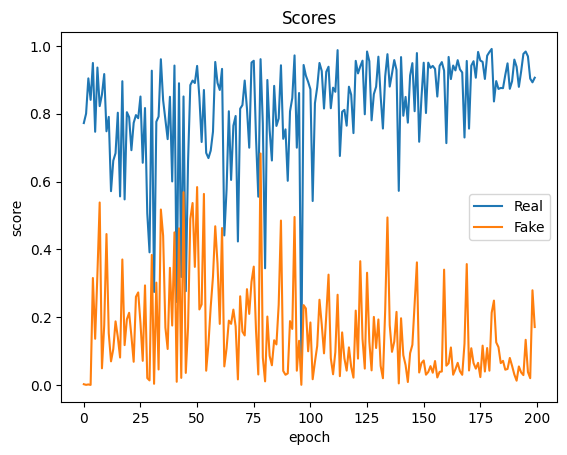

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');